<a href="https://colab.research.google.com/github/MuhammadBilalH/User_Complaints_Identification/blob/main/Intent_Classification_for_user_complaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [3]:
!pip install h2o

     |████████████████████████████████| 164.6MB 91kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.3-py2.py3-none-any.whl size=164649662 sha256=f24048b72c63040dc1fbcc0551480f1b9bb0f5cde82c1cc45090e896338d7f2a
  Stored in directory: /root/.cache/pip/wheels/0a/fd/63/96d322a27867a81a2904172a75aed5241913d603a4b8c4b277
Successfully built h2o


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import h2o
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from h2o.automl import H2OAutoML

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp81l76gek
  JVM stdout: /tmp/tmp81l76gek/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp81l76gek/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_6uckpo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
df=pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true',compression='zip',sep=',',quotechar='"')

In [8]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704


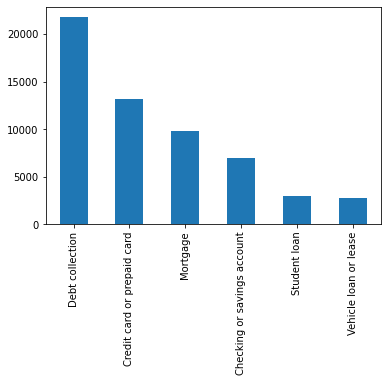

In [9]:
df['Product'].value_counts().plot(kind='bar')

In [10]:
df['Company'].value_counts()

CITIBANK, N.A.                             3226
CAPITAL ONE FINANCIAL CORPORATION          2711
BANK OF AMERICA, NATIONAL ASSOCIATION      2580
JPMORGAN CHASE & CO.                       2409
WELLS FARGO & COMPANY                      2001
                                           ... 
Tri-Counties Accounts Adjustment Bureau       1
MedShield, Inc.                               1
AmeriCash Holding LLC                         1
GVA Holdings, LLC                             1
ABSOLUTE CREDIT  LLC                          1
Name: Company, Length: 2197, dtype: int64

In [11]:
compl_df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})
compl_df.head()

,complaints,Product,Company
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc."


In [12]:
compl_df.Product.unique()

array(['Vehicle loan or lease', 'Debt collection',
       'Checking or savings account', 'Mortgage',
       'Credit card or prepaid card', 'Student loan'], dtype=object)

In [13]:
target={'Vehicle loan or lease':0,'Debt collection':1,'Checking or savings account':2,'Mortgage':3,'Credit card or prepaid card':4,'Student loan':5}

In [14]:
compl_df['target']=compl_df.Product.map(target)
compl_df.head()

,complaints,Product,Company,target
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,0
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings,1
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,0
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,2
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc.",1


In [15]:
X_train ,X_test = train_test_split(compl_df,test_size=0.8)

In [16]:
stemmer=nltk.stem.SnowballStemmer('english')


In [17]:
nltk.download('stopwords')
stop_words=set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
def tokenize(text):
  tokens = [word for word in nltk.word_tokenize(text) if (len(word)>3 and len(word.strip('Xx/'))>2 and len(re.sub('\d+', '', word.strip('Nn/')))>3)]
  tokens = map(str.lower,tokens)
  stems= [stemmer.stem(item) for item in tokens if (item not in stop_words)]
  return stems

In [19]:
vectorizer_TF=TfidfVectorizer(tokenizer=tokenize,stop_words=None,max_df=0.8,max_features=1000,lowercase=False,ngram_range=(1,2))
train_vector=vectorizer_TF.fit_transform(X_train.complaints)

In [20]:
train_vector.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10522895,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.1966791 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01330613,
        0.        ]])

In [21]:
vectorizer_TF.get_feature_names()

['abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'access account',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amex',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'assess',
 'asset',
 

In [22]:
test_vector = vectorizer_TF.transform(X_test.complaints)

In [23]:
X_train.shape

(11490, 4)

In [24]:
train_df=pd.DataFrame(train_vector.toarray(),columns=vectorizer_TF.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)],axis=1)
train_df.head()

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,...,violat fair,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would receiv,would take,write,written,wrong,wrote,xx/xx/2018,xx/xx/2019,xx/xx/2020,year,yesterday,target
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.14624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,4
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089085,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0577,0.0,0.078650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.119607,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.105229,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166504,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.076997,0.0,0.149317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.196679,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.093998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.046957,0.0,0.0,0.057888,0.0,0.0,0.0,0.060817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044946,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.046267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073626,0.0,0.000000,0.072702,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.535542,0.030951,0.0,3


In [25]:
test_df=pd.DataFrame(test_vector.toarray(),columns=vectorizer_TF.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)],axis=1)
test_df.head()

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,...,violat fair,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would receiv,would take,write,written,wrong,wrote,xx/xx/2018,xx/xx/2019,xx/xx/2020,year,yesterday,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201232,0.0,0.0,0.0,0.0,0.0,0.090876,0.0,0.090669,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.058996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.127970,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.125791,0.0,0.053796,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162845,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.167509,0.0,0.0,0.0,0.0,0.0,0.0,0.103558,0.0,0.000000,0.068172,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126908,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.045138,0.0,0.0,0.0,0.0,0.0,0.032845,0.0,0.0,0.071357,0.029244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.044136,0.0,0.094758,0.0,0.024804,0.0,0.0,0.0,0.0,0.0,0.055605,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.026902,0.0,0.051417,0.141673,0.0,0.0,0.0,0.0,0.0,0.0,0.032988,0.0,0.0,0.000000,0.0,0.022618,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.196741,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.094582,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.060245,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,3


In [26]:
h2o_train_df=h2o.H2OFrame(train_df)
h2o_test_df=h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [27]:
h2o_train_df['target']=h2o_train_df['target'].asfactor()
h2o_test_df['target']=h2o_test_df['target'].asfactor()

In [28]:
aml=H2OAutoML(max_models=10, seed=10, exclude_algos=["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)
x=vectorizer_TF.get_feature_names()
y='target'

In [29]:
aml.train(x=x,y=y,training_frame=h2o_train_df,validation_frame=h2o_test_df)

AutoML progress: |
18:40:38.665: Project: AutoML_20210120_184038654
18:40:38.666: Cross-validation disabled by user: no fold column nor nfolds > 1.
18:40:38.672: Setting stopping tolerance adaptively based on the training frame: 0.00932910509720565
18:40:38.672: Build control seed: 10
18:40:38.673: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
18:40:40.549: training frame: Frame key: automl_training_py_1_sid_9ff7    cols: 1001    rows: 10336  chunks: 14    size: 8603030  checksum: -6468816654188006920
18:40:40.553: validation frame: Frame key: py_2_sid_9ff7    cols: 1001    rows: 45963  chunks: 53    size: 37638355  checksum: -8381452028523594356
18:40:40.651: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_9ff7    cols: 1001    rows: 1154  chunks: 14    size: 1886930  checksum: -5333229762462279452
18:40:40.651: blending frame: NULL
18:40:40.651: respons

In [30]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
XGBoost_3_AutoML_20210120_184038,0.199047,0.451873,0.365793,0.133805,nan,nan
GBM_4_AutoML_20210120_184038,0.206699,0.599374,0.394408,0.155558,nan,nan
XGBoost_2_AutoML_20210120_184038,0.211779,0.492487,0.376473,0.141732,nan,nan
XGBoost_1_AutoML_20210120_184038,0.213816,0.480854,0.373707,0.139657,nan,nan
GBM_2_AutoML_20210120_184038,0.21458,0.550698,0.39965,0.15972,nan,nan
GBM_3_AutoML_20210120_184038,0.220876,0.546338,0.39433,0.155496,nan,nan
GBM_5_AutoML_20210120_184038,0.230779,0.584786,0.412657,0.170286,nan,nan
GBM_1_AutoML_20210120_184038,0.233237,0.572254,0.415542,0.172676,nan,nan
GLM_1_AutoML_20210120_184038,0.239436,0.511649,0.39022,0.152272,nan,nan
DRF_1_AutoML_20210120_184038,0.337044,0.696422,0.484599,0.234836,nan,nan


In [31]:
pred=aml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [32]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.11668533616821121
RMSE: 0.3415923537906128
LogLoss: 0.39203684974730735
Mean Per-Class Error: 0.1823916779621747
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,1324.0,467.0,56.0,85.0,236.0,30.0,0.397634,"874 / 2,198"
1,191.0,16032.0,162.0,273.0,636.0,150.0,0.080945,"1,412 / 17,444"
2,24.0,233.0,4692.0,70.0,593.0,9.0,0.165273,"929 / 5,621"
3,82.0,379.0,104.0,7079.0,197.0,30.0,0.100623,"792 / 7,871"
4,76.0,768.0,462.0,73.0,9117.0,14.0,0.132540,"1,393 / 10,510"
5,44.0,287.0,13.0,53.0,107.0,1815.0,0.217335,"504 / 2,319"
6,1741.0,18166.0,5489.0,7633.0,10886.0,2048.0,0.128451,"5,904 / 45,963"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.871549
1,2,0.952853
2,3,0.977830
3,4,0.990101
4,5,0.996932
5,6,1.000000


In [34]:
model_ids=list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out=h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20210120_184038


Model Summary: 


,,number_of_trees
0,,80.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.0431273617332061
RMSE: 0.20767128288043607
LogLoss: 0.15367524853301298
Mean Per-Class Error: 0.04905583948507799
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,426.0,27.0,1.0,0.0,21.0,0.0,0.103158,49 / 475
1,3.0,3834.0,13.0,16.0,45.0,6.0,0.021190,"83 / 3,917"
2,0.0,28.0,1203.0,1.0,17.0,0.0,0.036829,"46 / 1,249"
3,1.0,24.0,3.0,1678.0,14.0,1.0,0.024985,"43 / 1,721"
4,1.0,74.0,23.0,5.0,2313.0,2.0,0.043424,"105 / 2,418"
5,1.0,24.0,1.0,0.0,10.0,520.0,0.064748,36 / 556
6,432.0,4011.0,1244.0,1700.0,2420.0,529.0,0.035023,"362 / 10,336"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.964977
1,2,0.992550
2,3,0.997968
3,4,0.999710
4,5,0.999903
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.11668533616821121
RMSE: 0.3415923537906128
LogLoss: 0.39203684974730735
Mean Per-Class Error: 0.1823916779621747
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,1324.0,467.0,56.0,85.0,236.0,30.0,0.397634,"874 / 2,198"
1,191.0,16032.0,162.0,273.0,636.0,150.0,0.080945,"1,412 / 17,444"
2,24.0,233.0,4692.0,70.0,593.0,9.0,0.165273,"929 / 5,621"
3,82.0,379.0,104.0,7079.0,197.0,30.0,0.100623,"792 / 7,871"
4,76.0,768.0,462.0,73.0,9117.0,14.0,0.132540,"1,393 / 10,510"
5,44.0,287.0,13.0,53.0,107.0,1815.0,0.217335,"504 / 2,319"
6,1741.0,18166.0,5489.0,7633.0,10886.0,2048.0,0.128451,"5,904 / 45,963"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.871549
1,2,0.952853
2,3,0.977830
3,4,0.990101
4,5,0.996932
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2021-01-20 18:42:38,0.011 sec,0.0,0.833333,1.791759,0.766060,NaN,NaN,0.833333,1.791759,0.771338,NaN,NaN
1,,2021-01-20 18:42:40,2.935 sec,5.0,0.492222,0.708166,0.149961,NaN,NaN,0.511212,0.756226,0.175511,NaN,NaN
2,,2021-01-20 18:42:43,5.103 sec,10.0,0.393327,0.489573,0.129837,NaN,NaN,0.425822,0.564934,0.163371,NaN,NaN
3,,2021-01-20 18:42:45,7.199 sec,15.0,0.351779,0.397598,0.111939,NaN,NaN,0.395160,0.495261,0.154233,NaN,NaN
4,,2021-01-20 18:42:47,9.230 sec,20.0,0.327894,0.347288,0.099458,NaN,NaN,0.380596,0.463735,0.147031,NaN,NaN
5,,2021-01-20 18:42:49,11.445 sec,25.0,0.309916,0.312070,0.090267,NaN,NaN,0.370901,0.443526,0.142354,NaN,NaN
6,,2021-01-20 18:42:51,13.703 sec,30.0,0.295488,0.284144,0.082527,NaN,NaN,0.364472,0.430143,0.138807,NaN,NaN
7,,2021-01-20 18:42:54,16.049 sec,35.0,0.283040,0.262501,0.074110,NaN,NaN,0.359813,0.421162,0.136392,NaN,NaN
8,,2021-01-20 18:42:56,18.480 sec,40.0,0.271163,0.242705,0.066563,NaN,NaN,0.355808,0.413280,0.134891,NaN,NaN
9,,2021-01-20 18:42:59,20.954 sec,45.0,0.261053,0.226940,0.061436,NaN,NaN,0.352619,0.407959,0.132672,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,mortgag,6102.122070,1.000000,0.132572
1,debt,5327.113281,0.872994,0.115735
2,card,4554.185059,0.746328,0.098942
3,bank,2153.034912,0.352834,0.046776
4,collect,1949.879639,0.319541,0.042362
5,payment,1268.978027,0.207957,0.027569
6,student,1038.039429,0.170111,0.022552
7,vehicl,816.054321,0.133733,0.017729
8,navient,699.335876,0.114605,0.015193
9,account,691.564026,0.113332,0.015025



See the whole table with table.as_data_frame()


In [35]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_bin': 256,
  'max_delta_step': 0.0,
  'max_depth': 5,
  'min_child_weight': 3.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 6,
  'objective': 'multi:softprob',
  'seed': 12,
  'silent': True,
  'subsample': 0.8,
  'updater': 'grow_gpu_hist'},
 10000)

In [36]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix

In [38]:
xgb_clasf=xgb.XGBClassifier(n_estimators=100,learning_rate=0.008,max_depth=6,objective='multi:softprob',random_state=10,**{"updater": "grow_gpu"})

In [39]:
xgb_clasf.fit(train_vector,X_train['target'])

[19:29:09] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.008, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [40]:
predict=xgb_clasf.predict(test_vector)

In [42]:
cm=confusion_matrix(X_test.target,predict)
print(cm)

[[ 1159   586    75    66   273    39]
 [  191 15742   261   300   748   202]
 [   35   577  4177   113   699    20]
 [   50   722   175  6643   235    46]
 [   89  1495   502    85  8326    13]
 [   20   390    12    50   130  1717]]


In [43]:
print('Classification Report :\n',classification_report(X_test.target,predict))

Classification Report :
               precision    recall  f1-score   support

           0       0.75      0.53      0.62      2198
           1       0.81      0.90      0.85     17444
           2       0.80      0.74      0.77      5621
           3       0.92      0.84      0.88      7871
           4       0.80      0.79      0.80     10510
           5       0.84      0.74      0.79      2319

    accuracy                           0.82     45963
   macro avg       0.82      0.76      0.78     45963
weighted avg       0.82      0.82      0.82     45963



In [45]:
from sklearn.utils import class_weight
class_weights=list(class_weight.compute_class_weight('balanced',np.unique(X_train.target),X_train.target))

In [46]:
class_weights

[3.559479553903346,
 0.44246765249537895,
 1.385672937771346,
 0.9932572614107884,
 0.7137532612746925,
 3.03486529318542]

In [47]:
weights=np.ones(X_train.shape[0],dtype='float')
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [48]:
for i , val in enumerate(X_train.target):
  weights[i]=class_weights[val]
weights

array([0.71375326, 0.99325726, 0.44246765, ..., 0.44246765, 0.44246765,
       0.44246765])

In [49]:
xgb_clasf=xgb.XGBClassifier(n_estimators=100,learning_rate=0.05,max_depth=8,objective='multi:softprob',random_state=100,**{"updater": "grow_gpu"})

In [50]:
xgb_clasf.fit(train_vector,X_train.target,sample_weight=weights)

[19:43:36] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [51]:
predictions=xgb_clasf.predict(test_vector)
cm=confusion_matrix(X_test.target,predictions)
print(cm)

[[ 1672   250    63    58    80    75]
 [  680 15038   361   365   717   283]
 [  123   159  4742    95   474    28]
 [  354   250   135  6965    95    72]
 [  492   584   697   103  8497   137]
 [  154   184    14    36    24  1907]]


In [52]:
print('Classification Report :\n',classification_report(X_test.target,predictions))

Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.76      0.59      2198
           1       0.91      0.86      0.89     17444
           2       0.79      0.84      0.82      5621
           3       0.91      0.88      0.90      7871
           4       0.86      0.81      0.83     10510
           5       0.76      0.82      0.79      2319

    accuracy                           0.84     45963
   macro avg       0.79      0.83      0.80     45963
weighted avg       0.86      0.84      0.85     45963

